# Analysis of the network

In [1]:
analyze_network = "final"  # options: "best", "final", <parameter update step no>
noise_amplitude = 0.1  # if run analyses with noise, noise amplitude

show_figures = True  # True if running in jupyter notebook; False if running a .py file
running_from_data = True # True if code is running in the data folder next to the model.pth. if false, must run from training file

distractor_probability = 1.0

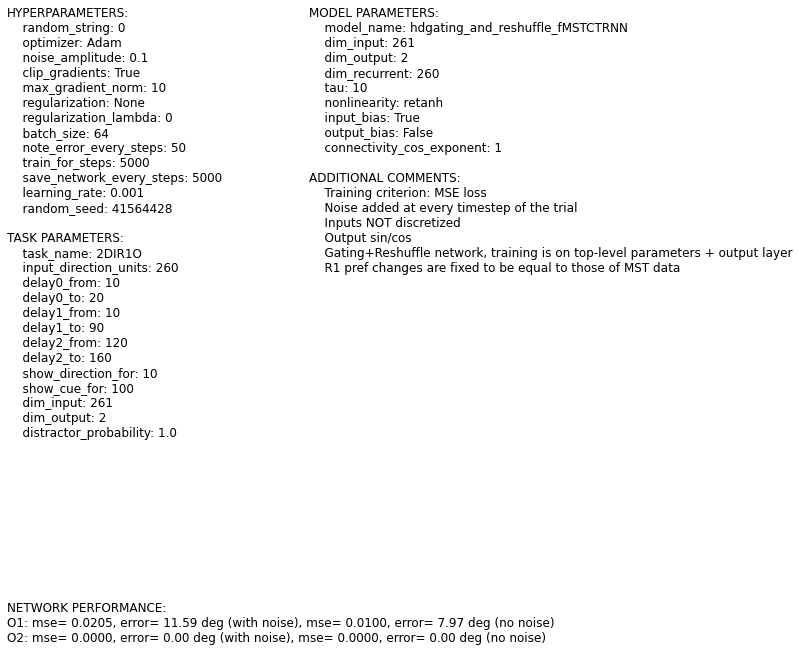

In [2]:
import argparse, json, time, random
import hashlib, torch, math, pathlib
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.collections import LineCollection
from task_and_training import *

with open(f"info.json", 'r', encoding='utf-8') as f:
    j = json.load(f)
hyperparameters = j["hyperparameters"]
task_parameters = j["task_parameters"]
model_parameters = j["model_parameters"]
additional_comments = j["additional_comments"]
directory = j["directory"]
figures_directory="figures/"
pathlib.Path(figures_directory+"a.a").parent.mkdir(parents=True, exist_ok=True)
def save_figure(figure_name):
    plt.savefig(figures_directory+figure_name+".pdf")
    if show_figures: 
        plt.show()
    
# some noise may be necessary to prevent dividing by 0 in some of the analyses
# if noise_amplitude == 0: noise_amplitude = 0.0001

task = Task()
model = Model()
if analyze_network.lower() == "best": network_filename = "model_best.pth"
elif analyze_network.lower() == "final": network_filename = f"model_parameterupdate{hyperparameters['train_for_steps']}.pth"
else: network_filename = f"model_parameterupdate{analyze_network}.pth"
model_state_dict = torch.load(network_filename, map_location=torch.device('cpu'))["model_state_dict"]
model.load_state_dict(model_state_dict)

resolution = 30
ORI_RES = 360//resolution
ORI_SET = torch.arange(0, 360, ORI_RES)
ORI_SET_SIZE = ORI_SET.shape[0]

# fix delays at median values for analysis
delay0, delay1, delay2 = task.get_median_delays()
delay1 = task_parameters["delay1_to"]  # max delay1 (to ensure convergence to final state for analysis)
show_direction_for = task_parameters["show_direction_for"]
show_cue_for = task_parameters["show_cue_for"]
total_time = show_direction_for+show_cue_for+delay0+delay2
t1, t1d = delay0, "before O1 presented"
t1_5, t1_5d = delay0+show_direction_for//2, "amid 01 presentation"
t2, t2d = delay0+show_direction_for, "after O1 presented"
t3, t3d = delay0+show_direction_for+delay1, "before O2 presented"
t3_5, t3_5d = delay0+show_direction_for+delay1+show_direction_for//2, "amid O2 presentation"
t4, t4d = delay0+show_direction_for+delay1+show_direction_for, "after O2 presented"
t5, t5d = delay0+show_direction_for+delay2, "before go cue"
t6, t6d = total_time-1, "at end of task"

# run the model on all possible directions 
ao_input, ao_target, ao_mask = task.make_all_integer_directions_batch(delay0, delay1, delay2, distractor_probability=distractor_probability, resolution=resolution)
ao_noise_mask = task.get_noise_mask(delay0, delay1, delay2)
ao_noise_mask = ao_noise_mask.repeat(ao_input.shape[0], 1).unsqueeze(2).repeat(1, 1, model.dim_recurrent)  # convert to (batch_size, total_time, dim_recurrent)
ao_noise = torch.randn_like(ao_noise_mask) * ao_noise_mask * noise_amplitude
ao_output, ao_h = model.forward(ao_input, noise=ao_noise)

# output model errors (with noise and without)
mse_o1, mse_o2, err_o1, err_o2 = task.calculate_errors(ao_target, ao_output, ao_mask, t5, t6)
ao_output_nn, ao_h_nn = model.forward(ao_input, noise=ao_noise*0)
mse_o1_nn, mse_o2_nn, err_o1_nn, err_o2_nn = task.calculate_errors(ao_target, ao_output_nn, ao_mask, t5, t6)

# for every timestep and every unit, calculate its activity in all trials
ao_data = torch.zeros((total_time, model.dim_recurrent, ORI_SET_SIZE, ORI_SET_SIZE))
for direction1 in range(ORI_SET_SIZE):
    for direction2 in range(ORI_SET_SIZE):
        o = ao_h[direction1 * ORI_SET_SIZE + direction2]
        ao_data[:, :, direction1, direction2] = o
        
# detach from autograd
ao_output = ao_output.detach()
ao_h = ao_h.detach()
ao_data = ao_data.detach()

fig = plt.figure(figsize=(12, 12))
plt.rc('font', **{'family': 'DejaVu Sans', 'weight': 'normal', 'size': 12})
info_string = ""
info_string += "hyperparameters:".upper()
for a, b in hyperparameters.items():
    info_string += f"\n    {a}: {b}"
info_string += "\n\n"
info_string += "task parameters:".upper()
for a, b in task_parameters.items():
    info_string += f"\n    {a}: {b}"
plt.text(0, 1, info_string, bbox=dict(facecolor='red', alpha=0.0), horizontalalignment='left', verticalalignment='top')
info_string = ""
info_string += "model parameters:".upper()
for a, b in model_parameters.items():
    info_string += f"\n    {a}: {b}"
info_string += "\n\n"
info_string += "additional comments:".upper()
for a in additional_comments:
    info_string += f"\n    {a}"
plt.text(0.45, 1, info_string, bbox=dict(facecolor='red', alpha=0.0), horizontalalignment='left', verticalalignment='top')
info_string = ""
info_string += ("Network performance:\n".upper())
info_string += (f"O1: mse= {mse_o1:.4f}, error= {err_o1:.2f} deg (with noise), mse= {mse_o1_nn:.4f}, error= {err_o1_nn:.2f} deg (no noise)\n")
info_string += (f"O2: mse= {mse_o2:.4f}, error= {err_o2:.2f} deg (with noise), mse= {mse_o2_nn:.4f}, error= {err_o2_nn:.2f} deg (no noise)\n")
plt.text(0, 0, info_string, bbox=dict(facecolor='red', alpha=0.0), horizontalalignment='left', verticalalignment='bottom')
plt.axis("off")
save_figure("network_info")

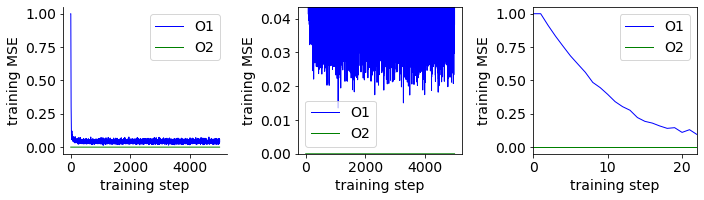

In [3]:
plt.rc('font', **{'family': 'DejaVu Sans', 'weight': 'normal', 'size': 14})
td = torch.load(f"training_dynamics.pt", map_location=torch.device('cpu'))
error_store, error_store_o1, error_store_o2, gradient_norm_store = td[0], td[1], td[2], td[3] 
fig = plt.figure(figsize=(10, 3))
ax = fig.add_subplot(1, 3, 1)
#plt.plot(error_store, "-", linewidth=5, color="k", label="O1+O2")
ax.plot(error_store_o1, "-", linewidth=1, color="b", label="O1")
ax.plot(error_store_o2, "-", linewidth=1, color="g", label="O2")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend()
#ax.set_ylim(0, 0.3)
ax.set_xlabel("training step")
ax.set_ylabel("training MSE")
ax = fig.add_subplot(1, 3, 2)
#plt.plot(error_store, "-", linewidth=5, color="k", label="O1+O2")
ax.plot(error_store_o1, "-", linewidth=1, color="b", label="O1")
ax.plot(error_store_o2, "-", linewidth=1, color="g", label="O2")
ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(True)
ax.legend()
ylim = torch.mean(error_store)
ax.set_ylim(0, ylim)
ax.set_xlabel("training step")
ax.set_ylabel("training MSE")
ax = fig.add_subplot(1, 3, 3)
#plt.plot(error_store, "-", linewidth=3, color="k", label="")
ax.plot(error_store_o1, "-", linewidth=1, color="b", label="O1")
ax.plot(error_store_o2, "-", linewidth=1, color="g", label="O2")
ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(True)
ax.legend()
xlim = min(torch.argmax((error_store_o1<0.1).long())*1, hyperparameters["train_for_steps"])
ax.set_xlim(0, xlim)
#ax.set_ylim(0, 0.3)
ax.set_xlabel("training step")
ax.set_ylabel("training MSE")
plt.tight_layout()
save_figure("training_errors")

# Clusters

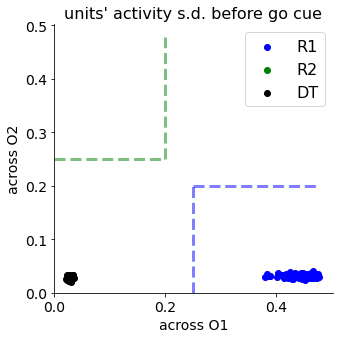

In [4]:
timestep, timestep_description = t5, t5d
cutoff_criterion = "box" # options: ratio, box
ring_cutoff = 2  # if ratio: minumum variance ratio to consider unit a ring unit
min_pri_var = 0.25  # if box: minimum variance in primary direction to consider unit a ring unit
max_sec_var = 0.20  # if box: maximum variance in the other direction to consider unit a ring unit

var_1 = torch.var(torch.mean(ao_data[timestep], dim=2), dim=1)**0.5 + 0.01
var_2 = torch.var(torch.mean(ao_data[timestep], dim=1), dim=1)**0.5 + 0.01


if cutoff_criterion == "ratio":
    R1_i = torch.where(var_1/var_2 > ring_cutoff)[0]
    R2_i = torch.where(var_2/var_1 > ring_cutoff)[0]
    DT_i = torch.tensor([x for x in range(model.dim_recurrent) if (x not in R1_i) and (x not in R2_i)], dtype=int)
elif cutoff_criterion == "box":
    R1_i = torch.where(torch.logical_and(var_1>min_pri_var, var_2<max_sec_var))[0]
    R2_i = torch.where(torch.logical_and(var_2>min_pri_var, var_1<max_sec_var))[0]
    DT_i = torch.tensor([x for x in range(model.dim_recurrent) if (x not in R1_i) and (x not in R2_i)], dtype=int)

mv = max(max(var_1), max(var_2))
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 1, 1)
plt.rc('font', **{'family': 'DejaVu Sans', 'weight': 'normal', 'size': 16})
if cutoff_criterion == "ratio":
    ax.plot([0, mv], [0, mv/ring_cutoff], "--b", linewidth=3, alpha=0.5)
    ax.plot([0, mv/ring_cutoff], [0, mv], "--g", linewidth=3, alpha=0.5)
elif cutoff_criterion == "box":
    ax.plot([min_pri_var, min_pri_var], [0, max_sec_var], "--b", linewidth=3, alpha=0.5)
    ax.plot([min_pri_var, mv], [max_sec_var, max_sec_var], "--b", linewidth=3, alpha=0.5)
    ax.plot([0, max_sec_var], [min_pri_var, min_pri_var], "--g", linewidth=3, alpha=0.5)
    ax.plot([max_sec_var, max_sec_var], [min_pri_var, mv], "--g", linewidth=3, alpha=0.5)
ax.scatter(var_1[R1_i], var_2[R1_i], color="b", label="R1")
ax.scatter(var_1[R2_i], var_2[R2_i], color="g", label="R2")
ax.scatter(var_1[DT_i], var_2[DT_i], color="k", label="DT")
ax.set_xlabel("across O1")
ax.set_ylabel("across O2")
ax.set_title(f"units' activity s.d. {timestep_description}", fontsize=16)
ax.set_xlim(0, mv*1.05)
ax.set_ylim(0, mv*1.05)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend()
plt.tight_layout()
save_figure("unit_allocations")

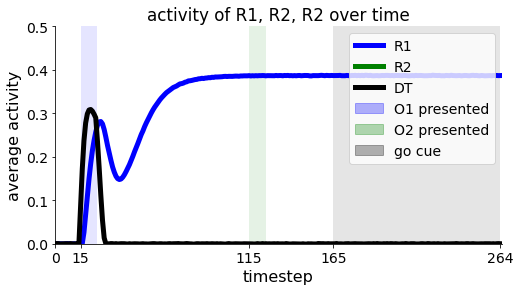

In [5]:
#plt.plot()
time = range(total_time)
plt.rc('font', **{'family': 'DejaVu Sans', 'weight': 'normal', 'size': 14})
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(1, 1, 1)
ax.plot(time, torch.mean(ao_h[:, :, R1_i], dim=[0, 2]).detach().numpy(), "b-", linewidth=5, markersize=10, label="R1")
ax.plot(time, torch.mean(ao_h[:, :, R2_i], dim=[0, 2]).detach().numpy(), "g-", linewidth=5, markersize=10, label="R2")
ax.plot(time, torch.mean(ao_h[:, :, DT_i], dim=[0, 2]).detach().numpy(), "k-", linewidth=5, markersize=10, label="DT")
ax.set_xlabel('timestep', fontsize=16)
ax.set_ylabel('average activity', fontsize=16)
ax.set_title(f'activity of R1, R2, R2 over time')

ax.set_xticks([0, t1, t3, t5, t6])
# add patches to visualize inputs
ax.axvspan(t1, t2, facecolor="b", alpha=0.1)
ax.axvspan(t3, t4, facecolor="g", alpha=0.1)
ax.axvspan(t5, t6, facecolor="k", alpha=0.1)
# add patches to legend
handles, labels = plt.gca().get_legend_handles_labels()
handles.append(mpatches.Patch(color='b', alpha=0.3, label='O1 presented'))
handles.append(mpatches.Patch(color='g', alpha=0.3, label='O2 presented'))
handles.append(mpatches.Patch(color='k', alpha=0.3, label='go cue'))
ax.legend(handles=handles, loc=1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.ylim(0, 0.5)
plt.xlim(0, total_time)
save_figure("cluster_activities")

# Preference changes

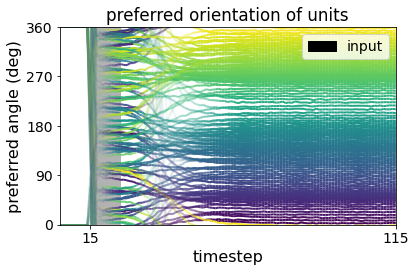

Opacity indicates mean unit activity (across all choices of O1 and O2), squared


In [6]:
alpha_for = "overall_activity"  # what the opacity will indicate the figure. options: overall_activity, tuning_strength

def calc_pref(units_i, timestep=t5, to=1, data=None, round_prefs=False):
    if data is None: data = ao_data
    w = torch.sum(data[timestep][units_i], dim=3-to).detach().numpy()
    a = np.angle(np.sum(w*np.exp(1j*(np.arange(ORI_SET_SIZE)/ORI_SET_SIZE*2*np.pi)).reshape(1, -1), axis=1)/ (np.sum(np.abs(w), axis=1)+0.01)) * 180 / np.pi
    a[a<0] = a[a<0]+360
    a = torch.tensor(a)
    if round_prefs: a = torch.round(a)
    return a
def calc_strength(units_i, timestep=t5, to=1, data=None, minimum_overall_activity_threshold=0.1):
    if data is None: data = ao_data
    w = torch.sum(data[timestep][units_i], dim=3-to).detach().numpy()
    a = np.abs(np.sum(w*np.exp(1j*(np.arange(ORI_SET_SIZE)/ORI_SET_SIZE*2*np.pi)).reshape(1, -1), axis=1)/ (np.sum(np.abs(w), axis=1)+0.01))
    #a = np.abs(np.sum(w*np.exp(1j*(np.arange(ORI_SET_SIZE)/ORI_SET_SIZE*2*np.pi)).reshape(1, -1), axis=1))
    #a[torch.mean(data[timestep][units_i], dim=(1, 2))<minimum_overall_activity_threshold] = 0
    a = torch.tensor(a)
    a *= torch.abs(torch.mean(data[timestep][units_i], dim=(1, 2)))
    return a
prefs_1 = []  # every unit's preferred O1
prefs_2 = []  # every unit's preferred O2
strengths_1 = []  # every unit's preferred O1
strengths_2 = []  # every unit's preferred O2
for timestep in range(total_time):
    prefs_1.append(calc_pref(range(model.dim_recurrent), timestep=timestep, to=1).unsqueeze(0))
    prefs_2.append(calc_pref(range(model.dim_recurrent), timestep=timestep, to=2).unsqueeze(0))
    strengths_1.append(calc_strength(range(model.dim_recurrent), timestep=timestep, to=1).unsqueeze(0))
    strengths_2.append(calc_strength(range(model.dim_recurrent), timestep=timestep, to=2).unsqueeze(0))
prefs_1 = torch.cat(prefs_1)
prefs_2 = torch.cat(prefs_2)
strengths_1 = torch.cat(strengths_1)
strengths_2 = torch.cat(strengths_2)

# sort units according to their preferred directions (don't sort DT)
R1_pref = prefs_1[t5-1][R1_i]
R2_pref = prefs_2[t5-1][R2_i]
DT_pref = prefs_1[t2-1][DT_i]
R1_i = R1_i.clone()[torch.argsort(R1_pref)]
R1_pref = R1_pref.clone()[torch.argsort(R1_pref)]
R2_i = R2_i.clone()[torch.argsort(R2_pref)]
R2_pref = R2_pref.clone()[torch.argsort(R2_pref)]
DT_i = DT_i.clone()[torch.argsort(DT_pref)]
DT_pref = DT_pref.clone()[torch.argsort(DT_pref)]
order_indices = torch.cat((R1_i, DT_i, R2_i))

fig = plt.figure(figsize=(6,4))
time = range(total_time)
ax = fig.add_subplot(1, 1, 1)
indices = np.copy(R1_i)
np.random.shuffle(indices)
for i in indices[::1]:
    if alpha_for == "overall_activity":
        alpha=torch.mean(ao_data[:, i]**2, dim=(1, 2))  # for alpha based on overall mean unit activity
    else:
        alpha=strengths_1[:, i]
    alpha*=5
    alpha[alpha>1] = 1

    # plots the lines corresponding to the preferred directions of units over time
    # deals with preferred directions of units crossing the 0/360 boundary (plots them nicely still)
    raw_preferences = prefs_1[:, i]
    raw_preferences[:t1] = 0
    d_preferences = raw_preferences[1:] - raw_preferences[:-1]
    d_preferences[d_preferences<-100] += 360
    d_preferences[d_preferences>100] -= 360
    new_preferences = torch.ones(raw_preferences.shape) * raw_preferences[0]
    new_preferences[1:] += torch.cumsum(d_preferences, 0)
    for diff in [-720, -360, 0, 360, 720]:
        points = np.vstack((time, new_preferences+diff)).T.reshape(-1, 1, 2)
        segments = np.hstack((points[:-1], points[1:]))
        lc = LineCollection(segments, alpha=alpha, color=plt.cm.viridis(prefs_1[-1, i].item()/360), lw=2)
        line = ax.add_collection(lc)
ax.set_xlabel('timestep', fontsize=16)
ax.set_ylabel('preferred angle (deg)', fontsize=16)
ax.set_title("preferred orientation of units")
t_to = t3 # (t1+t3)//2
ax.set_xticks([0, t1, t_to])
ax.set_yticks([0, 90, 180, 270, 360])
ax.set_xlim(t1-10, t_to)
ax.set_ylim(0, 360)
# add patches to visualize inputs
ax.axvspan(t1, t2, facecolor="k", alpha=0.3)
handles, labels = plt.gca().get_legend_handles_labels()
handles.append(mpatches.Patch(color='k', alpha=1.0, label='input'))
ax.legend(handles=handles, loc=1)
plt.tight_layout()
save_figure("preference_change_lines_simple")
if alpha_for == "overall_activity":
    print("Opacity indicates mean unit activity (across all choices of O1 and O2), squared")
else: 
    print("Opacity indicates strength of tuning to direction")

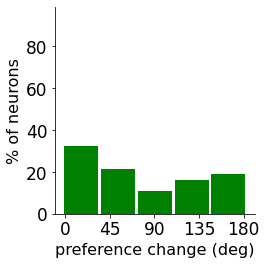

In [7]:
def calc_pref_ave(units_i, timestep_from, timestep_to, to=1, data=None, round_prefs=False):
    if data is None: data = ao_data
    w = torch.sum(data[timestep_from:timestep_to][:, units_i], dim=(0, 4-to)).detach().numpy()
    a = np.angle(np.sum(w*np.exp(1j*(np.arange(ORI_SET_SIZE)/ORI_SET_SIZE*2*np.pi)).reshape(1, -1), axis=1)/ (np.sum(np.abs(w), axis=1)+0.01)) * 180 / np.pi
    a[a<0] = a[a<0]+360
    a = torch.tensor(a)
    if round_prefs: a = torch.round(a)
    return a
# UNSTRETCHED
fig = plt.figure(figsize=(4, 4))
plt.rc('font', **{'family': 'DejaVu Sans', 'weight': 'normal', 'size': 17})
ylim = 99
ax = fig.add_subplot(1, 1, 1)
bins = 5
units_i = R1_i
cue_from, cue_to = t1, t2
delay_from, delay_to = t2+20, t3
prefc = calc_pref_ave(units_i, cue_from, cue_to, to=1)-calc_pref_ave(units_i, delay_from, delay_to, to=1)
prefc[prefc<-180] = prefc[prefc<-180]+360
prefc[prefc>180] = prefc[prefc>180]-360
prefc = torch.abs(prefc)
hist = torch.histc(prefc, bins = bins, min = 0, max = 180)
hist /= torch.sum(hist)
x = torch.arange(bins)/bins * 180
ax.bar(x*1.033+16, hist*100, align='center', width=180/bins/1.05, color="green")
#ax.set_title("O1 tuning, R1 units, first delay", fontsize=16)
ax.set_xlabel('preference change (deg)', fontsize=16)
ax.set_ylabel('% of neurons', fontsize=16)
ax.set_xticks(torch.arange(0, 181, 45))
ax.set_ylim(0, ylim)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
#plt.savefig("ccn_changepref_1.pdf", bbox_inches = 'tight')

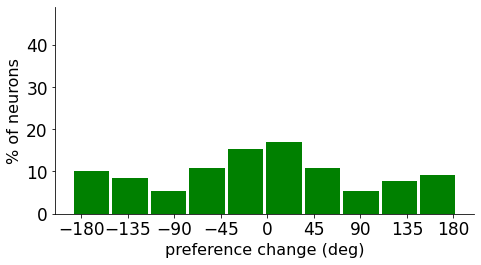

In [8]:
# UNSTRETCHED -180, 180
fig = plt.figure(figsize=(7, 4))
plt.rc('font', **{'family': 'DejaVu Sans', 'weight': 'normal', 'size': 17})
ylim = 99
ax = fig.add_subplot(1, 1, 1)
bins = 10
units_i = R1_i
cue_from, cue_to = t1, t2
delay_from, delay_to = t2+20, t3
prefc = calc_pref_ave(units_i, cue_from, cue_to, to=1)-calc_pref_ave(units_i, delay_from, delay_to, to=1)
prefc[prefc<-180] = prefc[prefc<-180]+360
prefc[prefc>180] = prefc[prefc>180]-360
#prefc = torch.abs(prefc)
hist = torch.histc(prefc, bins = bins, min = -180, max = 180)
hist /= torch.sum(hist)
x = torch.arange(-bins//2, bins//2)/bins * 180*2
ax.bar(x*1.033+16, hist*100, align='center', width=180/bins/1.05*2, color="green")
#ax.set_title("O1 tuning, R1 units, first delay", fontsize=16)
ax.set_xlabel('preference change (deg)', fontsize=16)
ax.set_ylabel('% of neurons', fontsize=16)
ax.set_xticks(torch.arange(-180, 181, 45))
ax.set_ylim(0, ylim//2)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
#plt.savefig("ccn_changepref_1.pdf", bbox_inches = 'tight')

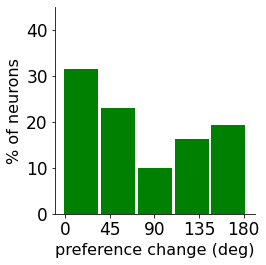

In [11]:
t_pc_from = t2-1
t_pc_to = t3-1
# UNSTRETCHED
fig = plt.figure(figsize=(4, 4))
plt.rc('font', **{'family': 'DejaVu Sans', 'weight': 'normal', 'size': 17})
ylim = 45
ax = fig.add_subplot(1, 1, 1)
bins = 5
units_i = R1_i
prefc = calc_pref(units_i, t_pc_from, to=1)-calc_pref(units_i, t_pc_to, to=1)
prefc[prefc<-180] = prefc[prefc<-180]+360
prefc[prefc>180] = prefc[prefc>180]-360
prefc = torch.abs(prefc)
hist = torch.histc(prefc, bins = bins, min = 0, max = 180)
hist /= torch.sum(hist)
x = torch.arange(bins)/bins * 180
ax.bar(x*1.033+16, hist*100, align='center', width=180/bins/1.05, color="green")
#ax.set_title("O1 tuning, R1 units, first delay", fontsize=16)
ax.set_xlabel('preference change (deg)', fontsize=16)
ax.set_ylabel('% of neurons', fontsize=16)
ax.set_xticks(torch.arange(0, 181, 45))
ax.set_ylim(0, ylim)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
#plt.savefig("ccn_changepref_1.pdf", bbox_inches = 'tight')

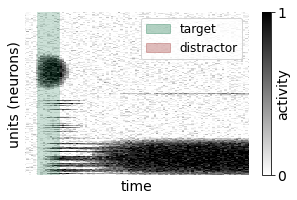

In [10]:
targetinput_color = "#006838"
distractor_color = "#97211F"
fig = plt.figure(figsize=(5, 3))
plt.rc('font', **{'family': 'DejaVu Sans', 'weight': 'normal', 'size': 14})

timesteps_to_take = np.concatenate((range((t3+t4)//2), range(t4, (t5+t6)//2)))
data_to_show = ao_data[0:t5, torch.cat((DT_i, R1_i)), 22, 16].T

plt.imshow(data_to_show*1, cmap='gray_r', vmin=0, vmax=1,interpolation='nearest', aspect='auto')
ax = plt.gca()
ax.axvspan(t1, t2, facecolor=targetinput_color, alpha=0.2)
ax.axvspan(t3, t4, facecolor=distractor_color, alpha=0.2)
handles, labels = plt.gca().get_legend_handles_labels()
handles.append(mpatches.Patch(color=targetinput_color, alpha=0.3, label='target'))
handles.append(mpatches.Patch(color=distractor_color, alpha=0.3, label='distractor'))
plt.ylabel("units (neurons)")
plt.xlabel("time")
#plt.colorbar(label="activity", ticks=[0, 1])
cb = plt.colorbar(ticks=[0, 1])
cb.set_label("activity", labelpad=-10)
plt.xticks([0, t1, t3, t5])
plt.xticks([])
plt.xlim(10, t5-60)
ax.legend(fontsize=12, handles=handles, loc=1)
#plt.axis('off')
plt.yticks([0, 20, 40, 60, 80, 100])
plt.yticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.savefig('../../test.pdf', bbox_inches='tight')

# Preference changes, 2

In [ ]:
alpha_for = "overall_activity"  # what the opacity will indicate the figure. options: overall_activity, tuning_strength

def calc_pref(units_i, timestep=t5, to=1, data=None, round_prefs=False):
    if data is None: data = ao_data
    w = torch.sum(data[timestep][units_i], dim=3-to).detach().numpy()
    a = np.angle(np.sum(w*np.exp(1j*(np.arange(ORI_SET_SIZE)/ORI_SET_SIZE*2*np.pi)).reshape(1, -1), axis=1)/ (np.sum(np.abs(w), axis=1)+0.01)) * 180 / np.pi
    a[a<0] = a[a<0]+360
    a = torch.tensor(a)
    if round_prefs: a = torch.round(a)
    return a
def calc_strength(units_i, timestep=t5, to=1, data=None, minimum_overall_activity_threshold=0.1):
    if data is None: data = ao_data
    w = torch.sum(data[timestep][units_i], dim=3-to).detach().numpy()
    a = np.abs(np.sum(w*np.exp(1j*(np.arange(ORI_SET_SIZE)/ORI_SET_SIZE*2*np.pi)).reshape(1, -1), axis=1)/ (np.sum(np.abs(w), axis=1)+0.01))
    #a = np.abs(np.sum(w*np.exp(1j*(np.arange(ORI_SET_SIZE)/ORI_SET_SIZE*2*np.pi)).reshape(1, -1), axis=1))
    #a[torch.mean(data[timestep][units_i], dim=(1, 2))<minimum_overall_activity_threshold] = 0
    a = torch.tensor(a)
    a *= torch.abs(torch.mean(data[timestep][units_i], dim=(1, 2)))
    return a
prefs_1 = []  # every unit's preferred O1
prefs_2 = []  # every unit's preferred O2
strengths_1 = []  # every unit's preferred O1
strengths_2 = []  # every unit's preferred O2
for timestep in range(total_time):
    prefs_1.append(calc_pref(range(model.dim_recurrent), timestep=timestep, to=1).unsqueeze(0))
    prefs_2.append(calc_pref(range(model.dim_recurrent), timestep=timestep, to=2).unsqueeze(0))
    strengths_1.append(calc_strength(range(model.dim_recurrent), timestep=timestep, to=1).unsqueeze(0))
    strengths_2.append(calc_strength(range(model.dim_recurrent), timestep=timestep, to=2).unsqueeze(0))
prefs_1 = torch.cat(prefs_1)
prefs_2 = torch.cat(prefs_2)
strengths_1 = torch.cat(strengths_1)
strengths_2 = torch.cat(strengths_2)

# sort units according to their preferred directions (don't sort DT)
R1_pref = prefs_1[t5-1][R1_i]
R2_pref = prefs_2[t5-1][R2_i]
R1_i = R1_i.clone()[torch.argsort(R1_pref)]
R1_pref = R1_pref.clone()[torch.argsort(R1_pref)]
R2_i = R2_i.clone()[torch.argsort(R2_pref)]
R2_pref = R2_pref.clone()[torch.argsort(R2_pref)]
order_indices = torch.cat((R1_i, DT_i, R2_i))

fig = plt.figure(figsize=(16, 8))
time = range(total_time)
ax = fig.add_subplot(2, 2, 1)
for i in R1_i:
    if alpha_for == "overall_activity":
        alpha=torch.mean(ao_data[:, i]**2, dim=(1, 2))  # for alpha based on overall mean unit activity
    else:
        alpha=strengths_1[:, i]
    ax.scatter(time, prefs_1[:, i], 25, alpha=alpha, color=plt.cm.rainbow(prefs_1[-1, i].item()/360))
ax.set_xlabel('timestep', fontsize=16)
ax.set_ylabel('preferred angle (deg)', fontsize=16)
ax.set_title("preferred O1 of R1 units")
ax.set_xlim(0, total_time)
ax.set_ylim(0, 360)
ax.set_xticks([0, t1, t3, t5, t6+1])
ax.set_yticks([0, 90, 180, 270, 360])
# add patches to visualize inputs
ax.axvspan(t1, t2, facecolor="b", alpha=0.3)
ax.axvspan(t3, t4, facecolor="g", alpha=0.3)
ax.axvspan(t5, t6+1, facecolor="k", alpha=0.1)
handles, labels = plt.gca().get_legend_handles_labels()
handles.append(mpatches.Patch(color='b', alpha=0.3, label='O1 presented'))
handles.append(mpatches.Patch(color='g', alpha=0.3, label='O2 presented'))
handles.append(mpatches.Patch(color='k', alpha=0.3, label='go cue'))
ax.legend(handles=handles, loc=5)

ax = fig.add_subplot(2, 2, 3)
for i in R1_i:
    if alpha_for == "overall_activity":
        alpha=torch.mean(ao_data[:, i]**2, dim=(1, 2))  # for alpha based on overall mean unit activity
    else:
        alpha=strengths_2[:, i]
    ax.scatter(time, prefs_2[:, i], 25, alpha=alpha, color=plt.cm.rainbow(prefs_2[-1, i].item()/360))
ax.set_xlabel('timestep', fontsize=16)
ax.set_ylabel('preferred angle (deg)', fontsize=16)
ax.set_title("preferred O2 of R1 units")
ax.set_xlim(0, total_time)
ax.set_ylim(0, 360)
ax.set_xticks([0, t1, t3, t5, t6+1])
ax.set_yticks([0, 90, 180, 270, 360])
# add patches to visualize inputs
ax.axvspan(t1, t2, facecolor="b", alpha=0.3)
ax.axvspan(t3, t4, facecolor="g", alpha=0.3)
ax.axvspan(t5, t6+1, facecolor="k", alpha=0.1)
handles, labels = plt.gca().get_legend_handles_labels()
handles.append(mpatches.Patch(color='b', alpha=0.3, label='O1 presented'))
handles.append(mpatches.Patch(color='g', alpha=0.3, label='O2 presented'))
handles.append(mpatches.Patch(color='k', alpha=0.3, label='go cue'))
#ax.legend(handles=handles, loc=5)

ax = fig.add_subplot(2, 2, 2)
for i in R2_i:
    if alpha_for == "overall_activity":
        alpha=torch.mean(ao_data[:, i]**2, dim=(1, 2))  # for alpha based on overall mean unit activity
    else:
        alpha=strengths_1[:, i]
    ax.scatter(time, prefs_1[:, i], 25, alpha=alpha, color=plt.cm.rainbow(prefs_1[-1, i].item()/360))
ax.set_xlabel('timestep', fontsize=16)
ax.set_ylabel('preferred angle (deg)', fontsize=16)
ax.set_title("preferred O1 of R2 units")
ax.set_xlim(0, total_time)
ax.set_ylim(0, 360)
ax.set_xticks([0, t1, t3, t5, t6+1])
ax.set_yticks([0, 90, 180, 270, 360])
# add patches to visualize inputs
ax.axvspan(t1, t2, facecolor="b", alpha=0.3)
ax.axvspan(t3, t4, facecolor="g", alpha=0.3)
ax.axvspan(t5, t6+1, facecolor="k", alpha=0.1)
handles, labels = plt.gca().get_legend_handles_labels()
handles.append(mpatches.Patch(color='b', alpha=0.3, label='O1 presented'))
handles.append(mpatches.Patch(color='g', alpha=0.3, label='O2 presented'))
handles.append(mpatches.Patch(color='k', alpha=0.3, label='go cue'))
#ax.legend(handles=handles, loc=5)

ax = fig.add_subplot(2, 2, 4)
for i in R2_i:
    if alpha_for == "overall_activity":
        alpha=torch.mean(ao_data[:, i]**2, dim=(1, 2))  # for alpha based on overall mean unit activity
    else:
        alpha=strengths_2[:, i]
    ax.scatter(time, prefs_2[:, i], 25, alpha=alpha, color=plt.cm.rainbow(prefs_2[-1, i].item()/360))
ax.set_xlabel('timestep', fontsize=16)
ax.set_ylabel('preferred angle (deg)', fontsize=16)
ax.set_title("preferred O2 of O2 units")
ax.set_xlim(0, total_time)
ax.set_ylim(0, 360)
ax.set_xticks([0, t1, t3, t5, t6+1])
ax.set_yticks([0, 90, 180, 270, 360])
# add patches to visualize inputs
ax.axvspan(t1, t2, facecolor="b", alpha=0.3)
ax.axvspan(t3, t4, facecolor="g", alpha=0.3)
ax.axvspan(t5, t6+1, facecolor="k", alpha=0.1)
handles, labels = plt.gca().get_legend_handles_labels()
handles.append(mpatches.Patch(color='b', alpha=0.3, label='O1 presented'))
handles.append(mpatches.Patch(color='g', alpha=0.3, label='O2 presented'))
handles.append(mpatches.Patch(color='k', alpha=0.3, label='go cue'))
#ax.legend(handles=handles, loc=5)
plt.tight_layout()
save_figure("preference_change_lines")
if alpha_for == "overall_activity":
    print("Opacity indicates mean unit activity (across all choices of O1 and O2), squared")
else: 
    print("Opacity indicates strength of tuning to direction")

In [ ]:
t_pc_from = t2-1
t_pc_to = t3-1
# UNSTRETCHED
fig = plt.figure(figsize=(4, 4))
plt.rc('font', **{'family': 'DejaVu Sans', 'weight': 'normal', 'size': 17})
ylim = 99
ax = fig.add_subplot(1, 1, 1)
bins = 5
units_i = R1_i
prefc = calc_pref(units_i, t_pc_from, to=1)-calc_pref(units_i, t_pc_to, to=1)
prefc[prefc<-180] = prefc[prefc<-180]+360
prefc[prefc>180] = prefc[prefc>180]-360
prefc = torch.abs(prefc)
hist = torch.histc(prefc, bins = bins, min = 0, max = 180)
hist /= torch.sum(hist)
x = torch.arange(bins)/bins * 180
ax.bar(x*1.033+16, hist*100, align='center', width=180/bins/1.05, color="green")
#ax.set_title("O1 tuning, R1 units, first delay", fontsize=16)
ax.set_xlabel('preference change (deg)', fontsize=16)
ax.set_ylabel('% of neurons', fontsize=16)
ax.set_xticks(torch.arange(0, 181, 45))
ax.set_ylim(0, ylim)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
#plt.savefig("ccn_changepref_1.pdf", bbox_inches = 'tight')

In [ ]:
# STRETCHED
fig = plt.figure(figsize=(4, 4))
plt.rc('font', **{'family': 'DejaVu Sans', 'weight': 'normal', 'size': 17})
ylim = 99
ax = fig.add_subplot(1, 1, 1)
bins = 5
units_i = R1_i
prefc = calc_pref(units_i, t_pc_from, to=1)-calc_pref(units_i, t_pc_to, to=1)
prefc[prefc<-180] = prefc[prefc<-180]+360
prefc[prefc>180] = prefc[prefc>180]-360
prefc = torch.abs(prefc)
hist = torch.histc(prefc, bins = bins, min = 0, max = 180)
hist /= torch.sum(hist)
x = torch.arange(bins)/bins * 180
ax.bar(x/180*225, hist*100, align='center', width=180/bins*1.15, color="green")
#ax.set_title("O1 tuning, R1 units, first delay", fontsize=16)
ax.set_xlabel('preference change (deg)', fontsize=16)
ax.set_ylabel('% of neurons', fontsize=16)
ax.set_xticks(torch.arange(0, 181, 45))
ax.set_ylim(0, ylim)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
#save_figure("../../../poster/ccn_prefchange_gating")

In [ ]:
fig = plt.figure(figsize=(12, 4))
ylim = 0.95
ax = fig.add_subplot(1, 3, 1)
bins = 10
units_i = R1_i
prefc = calc_pref(units_i, t_pc_from, to=1)-calc_pref(units_i, t_pc_to, to=1)
prefc[prefc<-180] = prefc[prefc<-180]+360
prefc[prefc>180] = prefc[prefc>180]-360
prefc = torch.abs(prefc)
hist = torch.histc(prefc, bins = bins, min = 0, max = 180)
hist /= torch.sum(hist)
x = torch.arange(bins)/bins * 180
ax.bar(x, hist, align='center', width=180/bins/1.1, color="k")
ax.set_title("O1 tuning, R1 units, first delay", fontsize=16)
ax.set_xlabel('Preference change (deg)', fontsize=16)
ax.set_ylabel('Proportion of units', fontsize=16)
ax.set_xticks(torch.arange(0, 181, 30))
ax.set_ylim(0, ylim)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax = fig.add_subplot(1, 3, 2)
bins = 10
units_i = R2_i
prefc = calc_pref(units_i, t2, to=1)-calc_pref(units_i, t3-1, to=1)
prefc[prefc<-180] = prefc[prefc<-180]+360
prefc[prefc>180] = prefc[prefc>180]-360
prefc = torch.abs(prefc)
hist = torch.histc(prefc, bins = bins, min = 0, max = 180)
hist /= torch.sum(hist)
x = torch.arange(bins)/bins * 180
ax.bar(x, hist, align='center', width=180/bins/1.1, color="k")
ax.set_title("O1 tuning, R2 units, first delay", fontsize=16)
ax.set_xlabel('Preference change (deg)', fontsize=16)
ax.set_ylabel('Proportion of units', fontsize=16)
ax.set_xticks(torch.arange(0, 181, 30))
ax.set_ylim(0, ylim)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax = fig.add_subplot(1, 3, 3)
bins = 10
units_i = R2_i
prefc = calc_pref(units_i, t4, to=2)-calc_pref(units_i, t5-1, to=2)
prefc[prefc<-180] = prefc[prefc<-180]+360
prefc[prefc>180] = prefc[prefc>180]-360
prefc = torch.abs(prefc)
hist = torch.histc(prefc, bins = bins, min = 0, max = 180)
hist /= torch.sum(hist)
x = torch.arange(bins)/bins * 180
ax.bar(x, hist, align='center', width=180/bins/1.1, color="k")
ax.set_title("O2 tuning, R2 units, second delay", fontsize=16)
ax.set_xlabel('Preference change (deg)', fontsize=16)
ax.set_ylabel('Proportion of units', fontsize=16)
ax.set_xticks(torch.arange(0, 181, 30))
ax.set_ylim(0, ylim)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
save_figure("preference_change_histograms")

# Tuning heatmaps

In [ ]:
def draw_tuning_heatmaps(timestep, timestep_description, data=None, order_indices=None):
    plt.close('all')
    if data is None: data=ao_data
    if order_indices is None: order_indices = np.arange(model.dim_recurrent)
    
    n = len(order_indices)
    sqt = math.ceil(n ** 0.5)
    fig, ax = plt.subplots(nrows=math.ceil(n/sqt), ncols=sqt, figsize=(6, 7))
    plt.rc('font', **{'family': 'DejaVu Sans', 'weight': 'normal', 'size': 14})
    for a in ax.ravel():
        a.title.set_visible(False)
        a.tick_params(left = False, labelleft = False , labelbottom = False, bottom = False)
        #a.axis('off')
    for i in range(n):
        a = ax[i // sqt][i % sqt]
        im = a.imshow(data[timestep][order_indices][i].detach().numpy(), vmin=0, vmax=1, origin="lower")
        
        # set color according to unit group
        if order_indices[i] in R1_i: color="b"
        elif order_indices[i] in R2_i: color="g"
        else: color="k"
        a.tick_params(color=color, labelcolor=color)
        for spine in a.spines.values():
            spine.set_edgecolor(color)
            spine.set_linewidth(2)
            # to reset:
            spine.set_edgecolor("k")  
            spine.set_linewidth(0.5)
        #[ for i in a.spines.itervalues()]
        
        #uncomment to see which unit has which id
        #a.title.set_visible(False)
        #a.set_title(f"{sor_i[i].item()}, {model.fc_h2y.weight[4, sor_i[i]].item():.2f}", fontsize=10)
        #a.set_title(f"#{sor_i[i].item()}| {model.fc_h2ah.weight[88, sor_i[i]].item():.2f}", fontsize=10)
        #a.set_title(f"#{sor_i[i].item()}| {model.fc_h2y.weight[4, sor_i[i]].item():.2f}", fontsize=10)
    #st = fig.suptitle(f"Tuning to directions {timestep_description}", fontsize=20)
    plt.tight_layout(pad=2)
    fig.supxlabel('direction2 (0 to 360 deg)', fontsize=14)
    fig.supylabel('direction1 (0 to 360 deg)               ', fontsize=14)
    fig.subplots_adjust(hspace=0.1, wspace=0.1)
    #fig.subplots_adjust(right=0.9)
    cbar = fig.colorbar(im, ax=ax.ravel().tolist(), label=f"every unit's activation {timestep_description}\n", location="top")
    cbar.ax.tick_params(labelsize=16)
    return fig
print("Units sorted first by cluster, then within R1 and R2 by their preferred O1 and O2, respectively")
draw_tuning_heatmaps(t2, t2d, order_indices=order_indices); save_figure("tuning_heatmaps_t2")
draw_tuning_heatmaps(t3, t3d, order_indices=order_indices); save_figure("tuning_heatmaps_t3")
draw_tuning_heatmaps(t4, t4d, order_indices=order_indices); save_figure("tuning_heatmaps_t4")
draw_tuning_heatmaps(t5, t5d, order_indices=order_indices); save_figure("tuning_heatmaps_t5")
draw_tuning_heatmaps(t6, t6d, order_indices=order_indices); save_figure("tuning_heatmaps_t6")

# Connectivity

In [ ]:
timestep, timestep_description = t5, t5d

# sort units again according to pref. direction
R1_i = R1_i.clone()[torch.argsort(R1_pref)]
R1_pref = R1_pref.clone()[torch.argsort(R1_pref)]
R2_i = R2_i.clone()[torch.argsort(R2_pref)]
R2_pref = R2_pref.clone()[torch.argsort(R2_pref)]


fig = plt.figure(figsize=(16, 5))
plt.rc('font', **{'family': 'DejaVu Sans', 'weight': 'normal', 'size': 14})

ax = fig.add_subplot(1, 2, 1)
# find closest sin and cos curves (least squares)
min_k_sin, min_k_cos, min_err_sin, min_err_cos = -1, -1, 1e10, 1e10
for k in range(200):
    err = torch.sum((model.fc_h2y.weight[:, R1_i][0]-torch.sin(R1_pref/180*3.14)/k)**2)
    if err<min_err_sin: min_k_sin=k;min_err_sin=err
    err = torch.sum((model.fc_h2y.weight[:, R1_i][1]-torch.cos(R1_pref/180*3.14)/k)**2)
    if err<min_err_cos: min_k_cos=k;min_err_cos=err
ax.plot(R1_pref.cpu().detach().numpy(), torch.sin(R1_pref/180*3.14).cpu().detach().numpy()/min_k_sin, 
         "k-", linewidth=2.5, label=f"sin(2x)/{min_k_sin}")
ax.plot(R1_pref.cpu().detach().numpy(), torch.cos(R1_pref/180*3.14).cpu().detach().numpy()/min_k_cos, 
         "k--", linewidth=2.5, label=f"cos(2x)/{min_k_cos}")
ax.plot(R1_pref.cpu().detach().numpy(), model.fc_h2y.weight[:, R1_i][0].cpu().detach().numpy(), 
         "b-", linewidth=3.5, label="R1->sin(O1)")
ax.plot(R1_pref.cpu().detach().numpy(), model.fc_h2y.weight[:, R1_i][1].cpu().detach().numpy(), 
         "-", color="darkblue", linewidth=3.5, label="R1->cos(O1)", alpha=1)
if len(R2_i)>0:  # if R2 exists (usually a proxy for whether the task involves O2)
    ax.plot(R1_pref.cpu().detach().numpy(), model.fc_h2y.weight[:, R1_i][2].cpu().detach().numpy(), 
             "y-", linewidth=3.5, label="R1->sin(O2)", alpha=0.5)
    ax.plot(R1_pref.cpu().detach().numpy(), model.fc_h2y.weight[:, R1_i][3].cpu().detach().numpy(), 
             "y--", linewidth=3.5, label="R1->cos(O2)", alpha=0.5)
ax.set_xlabel('preferred direction (deg)', fontsize=18)
ax.set_ylabel('weight', fontsize=18)
ax.set_title(f'R1->OUT connectivity ({timestep_description})')
ax.legend(loc=3)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax = fig.add_subplot(1, 2, 2)
# find closest sin and cos
if len(R2_i)>0:  # if R2 exists (usually a proxy for whether the task involves O2)
    min_k_sin, min_k_cos, min_err_sin, min_err_cos = -1, -1, 1e10, 1e10
    for k in range(200):
        err = torch.sum((model.fc_h2y.weight[:, R2_i][2]-torch.sin(R2_pref/180*3.14)/k)**2)
        if err<min_err_sin: min_k_sin=k;min_err_sin=err
        err = torch.sum((model.fc_h2y.weight[:, R2_i][3]-torch.cos(R2_pref/180*3.14)/k)**2)
        if err<min_err_cos: min_k_cos=k;min_err_cos=err
    ax.plot(R2_pref.cpu().detach().numpy(), torch.sin(R2_pref/180*3.14).cpu().detach().numpy()/min_k_sin, 
             "k-", linewidth=2.5, label=f"sin(2x)/{min_k_sin}")
    ax.plot(R2_pref.cpu().detach().numpy(), torch.cos(R2_pref/180*3.14).cpu().detach().numpy()/min_k_cos, 
             "k--", linewidth=2.5, label=f"cos(2x)/{min_k_cos}")
    ax.plot(R2_pref.cpu().detach().numpy(), model.fc_h2y.weight[:, R2_i][0].cpu().detach().numpy(), 
             "y-", linewidth=3.5, label="R2 to sin(O1)", alpha=0.5)
    ax.plot(R2_pref.cpu().detach().numpy(), model.fc_h2y.weight[:, R2_i][1].cpu().detach().numpy(), 
             "y--", linewidth=3.5, label="R2 to cos(O1)", alpha=0.5)
    ax.plot(R2_pref.cpu().detach().numpy(), model.fc_h2y.weight[:, R2_i][2].cpu().detach().numpy(), 
             "-", color="lime", linewidth=3.5, label="R2 to sin(O2)")
    ax.plot(R2_pref.cpu().detach().numpy(), model.fc_h2y.weight[:, R2_i][3].cpu().detach().numpy(), 
             "-", color="g", linewidth=3.5, label="R2 to cos(O2)")
#plt.axhline(y=O1_error_no_reset, color='r', linestyle='--', label="R1 error, no reset")
#plt.axhline(y=O2_error_no_reset, color='b', linestyle='--', label="R2 error, no reset")
ax.set_xlabel('preferred direction (deg)', fontsize=18)
ax.set_ylabel('weight', fontsize=18)
ax.set_title(f'R2->OUT connectivity ({timestep_description})')
ax.legend(loc=3)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
save_figure("ring_output_connectivity")

In [ ]:
def get_connplot_graph(units1_id=None, unit1_pref=None, units2_id=None, unit2_pref=None, sm=0):
    weight_matrix = None  # different models may store weights differently
    try: 
        weight_matrix = model.fc_h2ah.weight 
    except:
        weight_matrix = model.W_h_ah
    distances_weights = {}
    distances = []
    weights = []
    for i in range(len(units1_id)):
        for j in range(len(units2_id)):
            for k in range(-sm//2, sm//2+1):
                if j == i: continue
                diff = (unit2_pref[j]-unit1_pref[i]).item()
                if diff > 180: diff -= 360
                if diff < -180: diff += 360
                diff += k
                #print(diff, end=" ")
                #diff = (diff + 180 + 90) % 180 - 90
                w_ij = weight_matrix[units2_id[j], units1_id[i]]# + model.fc_x2ah.bias[units_id[i]]#/direction_neurons# weight from i to j 
                distances.append(diff)
                weights.append(w_ij.item())
                if diff not in distances_weights: distances_weights[diff] = []
                distances_weights[diff].append(w_ij.item())
    
    #print(distances_weights)
    o1_distances = np.array(sorted(distances_weights.keys()))
    o1_weights = [sum(distances_weights[diff])/len(distances_weights[diff]) for diff in o1_distances]
    o1_weights_std = [np.std(distances_weights[diff]) for diff in o1_distances]
    return distances, weights, torch.tensor(o1_distances), torch.tensor(o1_weights), torch.tensor(o1_weights_std)
def get_connplot_iu_graph(units_id, unit_pref, sm=0):
    weight_matrix = None  # different models may store weights differently
    try: 
        weight_matrix = model.fc_x2ah.weight 
    except:
        weight_matrix = model.W_x_ah
    distances_weights = {}
    distances = []
    weights = []
    for i in range(len(units_id)):
        for j in range(task_parameters["input_direction_units"]):
            for k in range(-sm//2, sm//2+1):
                if j == i: continue
                diff = (unit_pref[i]-round(360*j/task_parameters["input_direction_units"])).item()
                if diff > 180: diff -= 360
                if diff < -180: diff += 360
                diff += k
                #print(diff, end=" ")
                #diff = (diff + 180 + 90) % 180 - 90
                w_ij = weight_matrix[units_id[i], j]# + model.fc_x2ah.bias[units_id[i]]/20#/direction_neurons# weight from i to j 
                distances.append(diff)
                weights.append(w_ij.item())
                if diff not in distances_weights: distances_weights[diff] = []
                distances_weights[diff].append(w_ij.item())
    
    #print(distances_weights)
    o1_distances = np.array(sorted(distances_weights.keys()))
    o1_weights = [sum(distances_weights[diff])/len(distances_weights[diff]) for diff in o1_distances]
    o1_weights_std = [np.std(distances_weights[diff]) for diff in o1_distances]
    return distances, weights, torch.tensor(o1_distances), torch.tensor(o1_weights), torch.tensor(o1_weights_std)
def scatter_r_weights(ax, timestep, timestep_description, units_d, units_id, pref_to, ylim, alpha=0.05, show_line=False, sm=5):
    units_pref = calc_pref(units_id, timestep, to=pref_to)
    distances, weights, _, _, _ = get_connplot_graph(units_id, units_pref, units_id, units_pref, sm=sm)
    ax.scatter(distances, weights, 20, alpha=alpha, color="k", edgecolors='none')
    if show_line: ax.axhline(y=0.0, color='r', linestyle='--', linewidth=3)
    ax.set_ylim(-ylim, ylim)
    ax.set_xlim(-180, 180)
    ax.set_title(f"{units_d}->{units_d} {timestep_description}")
    ax.set_xlabel(f"difference in preferred O{pref_to} (deg)")
    ax.set_ylabel("weight")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
def scatter_ir_weights(ax, timestep, timestep_description, units_d, units_id, pref_to, ylim, alpha=0.05, show_line=False, sm=5):
    units_pref = calc_pref(units_id, timestep, to=pref_to)
    distances, weights, _, _, _ = get_connplot_iu_graph(units_id, units_pref, sm=sm)
    ax.scatter(distances, weights, 20, alpha=alpha, color="k")
    if show_line: ax.axhline(y=0.0, color='r', linestyle='--', linewidth=3)
    ax.set_ylim(-ylim, ylim)
    ax.set_xlim(-180, 180)
    ax.set_title(f"IN->{units_d} {timestep_description}")
    ax.set_xlabel(f"difference in preferred O{pref_to} (deg)")
    ax.set_ylabel("weight")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
def scatter_r_weights_smooth(ax, timestep, timestep_description, units_d, units_id, pref_to, ylim, show_line=False, sm=5, color="k"):
    units_pref = calc_pref(units_id, timestep, to=pref_to, round_prefs=True)
    distances, weights, o1_distances, o1_weights, o1_weights_std = get_connplot_graph(units_id, units_pref, units_id, units_pref, sm=sm)
    o1_weights = o1_weights[torch.argsort(o1_distances)]
    o1_weights_std = o1_weights_std[torch.argsort(o1_distances)]
    o1_distances = o1_distances[torch.argsort(o1_distances)]
    ax.fill_between(o1_distances, o1_weights-o1_weights_std, o1_weights+o1_weights_std, color=color, alpha=0.3, linewidth=0)
    ax.plot(o1_distances, o1_weights, "-", linewidth=4, label=units_d+"->"+units_d, color=color)
    
    if show_line: ax.axhline(y=0.0, color='r', linestyle='--', linewidth=3)
    ax.set_ylim(-ylim, ylim)
    ax.set_xlim(-180, 180)
    ax.set_title(f"{units_d}->{units_d} {timestep_description}")
    ax.set_xlabel(f"difference in preferred O{pref_to} (deg)")
    ax.set_ylabel("weight")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
def scatter_rr_weights_smooth(ax, timestep, timestep_description, units_from_d, units_from_id, pref_from, units_to_d, units_to_id, pref_to, ylim, show_line=False, sm=5, color="k"):
    units_from_pref = calc_pref(units_from_id, timestep, to=pref_from, round_prefs=True)
    units_to_pref = calc_pref(units_to_id, timestep, to=pref_to, round_prefs=True)
    distances, weights, o1_distances, o1_weights, o1_weights_std = get_connplot_graph(units_from_id, units_from_pref, units_to_id, units_to_pref, sm=sm)
    o1_weights = o1_weights[torch.argsort(o1_distances)]
    o1_weights_std = o1_weights_std[torch.argsort(o1_distances)]
    o1_distances = o1_distances[torch.argsort(o1_distances)]
    ax.fill_between(o1_distances, o1_weights-o1_weights_std, o1_weights+o1_weights_std, color=color, alpha=0.3, linewidth=0)
    ax.plot(o1_distances, o1_weights, "-", linewidth=4, label=units_from_d+"->"+units_to_d, color=color)
    
    if show_line: ax.axhline(y=0.0, color='r', linestyle='--', linewidth=3)
    ax.set_ylim(-ylim, ylim)
    ax.set_xlim(-180, 180)
    ax.set_title(f"{units_from_d}->{units_to_d} {timestep_description}")
    ax.set_xlabel(f"difference in preferred O{pref_to}({units_to_d}) and O{pref_from}({units_from_d}) (deg)")
    ax.set_ylabel("weight")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
def scatter_ir_weights_smooth(ax, timestep, timestep_description, units_d, units_id, pref_to, ylim, show_line=False, sm=5, color="k"):
    units_pref = calc_pref(units_id, timestep, to=pref_to, round_prefs=True)    
    distances, weights, o1_distances, o1_weights, o1_weights_std = get_connplot_iu_graph(units_id, units_pref, sm=sm)
    o1_weights = o1_weights[torch.argsort(o1_distances)]
    o1_weights_std = o1_weights_std[torch.argsort(o1_distances)]
    o1_distances = o1_distances[torch.argsort(o1_distances)]
    ax.fill_between(o1_distances, o1_weights-o1_weights_std, o1_weights+o1_weights_std, color=color, alpha=0.3, linewidth=0)
    ax.plot(o1_distances, o1_weights, "-", linewidth=4, label="IN->"+units_d, color=color)
    
    if show_line: ax.axhline(y=0.0, color='r', linestyle='--', linewidth=3)
    ax.set_ylim(-ylim, ylim)
    ax.set_xlim(-180, 180)
    ax.set_title(f"IN->{units_d} {timestep_description}")
    ax.set_xlabel(f"difference in preferred O{pref_to} (deg)")
    ax.set_ylabel("weight")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

In [ ]:
show_line = True  # show line at y=0
sm = 5  # amount of smoothing
r_ylim = 0.25
ir_ylim = 0.25

fig = plt.figure(figsize=(16, 8))
plt.rc('font', **{'family': 'DejaVu Sans', 'weight': 'normal', 'size': 14})
scatter_r_weights_smooth(fig.add_subplot(2, 3, 1), t1_5, t1_5d, "R1", R1_i, 1, r_ylim, sm=sm, show_line=show_line)
scatter_r_weights_smooth(fig.add_subplot(2, 3, 2), t3, t3d, "R1", R1_i, 1, r_ylim, sm=sm, show_line=show_line)
scatter_r_weights_smooth(fig.add_subplot(2, 3, 3), t3_5, t3_5d, "R1", R1_i, 1, r_ylim, sm=sm, show_line=show_line)
scatter_ir_weights_smooth(fig.add_subplot(2, 3, 4), t1_5, t1_5d, "R1", R1_i, 1, ir_ylim, sm=sm, show_line=show_line)
scatter_ir_weights_smooth(fig.add_subplot(2, 3, 5), t3, t3d, "R1", R1_i, 1, ir_ylim, sm=sm, show_line=show_line)
scatter_ir_weights_smooth(fig.add_subplot(2, 3, 6), t3_5, t3_5d, "R1", R1_i, 1, ir_ylim, sm=sm, show_line=show_line)
plt.tight_layout()
save_figure("r1_r1_weights")

In [ ]:
show_line = True  # show line at y=0
sm = 5  # amount of smoothing
r_ylim = 0.3
ir_ylim = 0.3

fig = plt.figure(figsize=(16, 8))
plt.rc('font', **{'family': 'DejaVu Sans', 'weight': 'normal', 'size': 14})
scatter_r_weights_smooth(fig.add_subplot(2, 3, 1), t1_5, t1_5d, "R2", R2_i, 1, r_ylim, sm=sm, show_line=show_line)
scatter_r_weights_smooth(fig.add_subplot(2, 3, 2), t3, t3d, "R2", R2_i, 1, r_ylim, sm=sm, show_line=show_line)
scatter_r_weights_smooth(fig.add_subplot(2, 3, 3), t3_5, t3_5d, "R2", R2_i, 2, r_ylim, sm=sm, show_line=show_line)
scatter_ir_weights_smooth(fig.add_subplot(2, 3, 4), t1_5, t1_5d, "R2", R2_i, 1, ir_ylim, sm=sm, show_line=show_line)
scatter_ir_weights_smooth(fig.add_subplot(2, 3, 5), t3, t3d, "R2", R2_i, 1, ir_ylim, sm=sm, show_line=show_line)
scatter_ir_weights_smooth(fig.add_subplot(2, 3, 6), t3_5, t3_5d, "R2", R2_i, 2, ir_ylim, sm=sm, show_line=show_line)
plt.tight_layout()
save_figure("r2_r2_weights")

In [ ]:
show_line = True  # show line at y=0
sm = 5  # amount of smoothing
r_ylim = 0.2
#ir_ylim = 0.1

fig = plt.figure(figsize=(16, 8))
plt.rc('font', **{'family': 'DejaVu Sans', 'weight': 'normal', 'size': 14})
scatter_rr_weights_smooth(fig.add_subplot(2, 3, 1), t1_5, t1_5d, "R1", R1_i, 1, "R2", R2_i, 1, r_ylim, sm=sm, show_line=show_line)
scatter_rr_weights_smooth(fig.add_subplot(2, 3, 2), t3, t3d, "R1", R1_i, 1, "R2", R2_i, 1, r_ylim, sm=sm, show_line=show_line)
scatter_rr_weights_smooth(fig.add_subplot(2, 3, 3), t3_5, t3_5d, "R1", R1_i, 1, "R2", R2_i, 2, r_ylim, sm=sm, show_line=show_line)
scatter_rr_weights_smooth(fig.add_subplot(2, 3, 4), t1_5, t1_5d, "R2", R2_i, 1, "R1", R1_i, 1, r_ylim, sm=sm, show_line=show_line)
scatter_rr_weights_smooth(fig.add_subplot(2, 3, 5), t3, t3d, "R2", R2_i, 1, "R1", R1_i, 1, r_ylim, sm=sm, show_line=show_line)
scatter_rr_weights_smooth(fig.add_subplot(2, 3, 6), t3_5, t3_5d, "R2", R2_i, 2, "R1", R1_i, 1, r_ylim, sm=sm, show_line=show_line)
plt.tight_layout()
save_figure("r1_r2_weights_1")

In [ ]:
show_line = True  # show line at y=0
sm = 5  # amount of smoothing
r_ylim = 0.2
#ir_ylim = 0.1

fig = plt.figure(figsize=(16, 8))
plt.rc('font', **{'family': 'DejaVu Sans', 'weight': 'normal', 'size': 14})
scatter_rr_weights_smooth(fig.add_subplot(2, 3, 1), t4, t4d, "R1", R1_i, 1, "R2", R2_i, 2, r_ylim, sm=sm, show_line=show_line)
scatter_rr_weights_smooth(fig.add_subplot(2, 3, 2), t5, t5d, "R1", R1_i, 1, "R2", R2_i, 2, r_ylim, sm=sm, show_line=show_line)
scatter_rr_weights_smooth(fig.add_subplot(2, 3, 3), t6, t6d, "R1", R1_i, 1, "R2", R2_i, 2, r_ylim, sm=sm, show_line=show_line)
scatter_rr_weights_smooth(fig.add_subplot(2, 3, 4), t4, t4d, "R2", R2_i, 2, "R1", R1_i, 1, r_ylim, sm=sm, show_line=show_line)
scatter_rr_weights_smooth(fig.add_subplot(2, 3, 5), t5, t5d, "R2", R2_i, 2, "R1", R1_i, 1, r_ylim, sm=sm, show_line=show_line)
scatter_rr_weights_smooth(fig.add_subplot(2, 3, 6), t6, t6d, "R2", R2_i, 2, "R1", R1_i, 1, r_ylim, sm=sm, show_line=show_line)
plt.tight_layout()
save_figure("r1_r2_weights_2")

In [ ]:
show_line = True  # show line at y=0
sm = 5  # amount of smoothing
alpha_r = 0.4 / sm
alpha_ir = 0.25 / sm
r_ylim = 0.25
ir_ylim = 0.25

fig = plt.figure(figsize=(16, 8))
plt.rc('font', **{'family': 'DejaVu Sans', 'weight': 'normal', 'size': 14})
scatter_r_weights(fig.add_subplot(2, 3, 1), t1_5, t1_5d, "R1", R1_i, 1, r_ylim, sm=sm, show_line=show_line, alpha=alpha_r)
scatter_r_weights(fig.add_subplot(2, 3, 2), t3, t3d, "R1", R1_i, 1, r_ylim, sm=sm, show_line=show_line, alpha=alpha_r)
scatter_r_weights(fig.add_subplot(2, 3, 3), t3_5, t3_5d, "R1", R1_i, 1, r_ylim, sm=sm, show_line=show_line, alpha=alpha_r)
scatter_ir_weights(fig.add_subplot(2, 3, 4), t1_5, t1_5d, "R1", R1_i, 1, ir_ylim, sm=sm, show_line=show_line, alpha=alpha_ir)
scatter_ir_weights(fig.add_subplot(2, 3, 5), t3, t3d, "R1", R1_i, 1, ir_ylim, sm=sm, show_line=show_line, alpha=alpha_ir)
scatter_ir_weights(fig.add_subplot(2, 3, 6), t3_5, t3_5d, "R1", R1_i, 1, ir_ylim, sm=sm, show_line=show_line, alpha=alpha_ir)
plt.tight_layout()
save_figure("r1_r1_weights_raw")

In [ ]:
show_line = True  # show line at y=0
sm = 5  # amount of smoothing
alpha_r = 0.4 / sm
alpha_ir = 0.25 / sm
r_ylim = 0.3
ir_ylim = 0.3

fig = plt.figure(figsize=(16, 8))
plt.rc('font', **{'family': 'DejaVu Sans', 'weight': 'normal', 'size': 14})
scatter_r_weights(fig.add_subplot(2, 3, 1), t1_5, t1_5d, "R2", R2_i, 1, r_ylim, sm=sm, show_line=show_line, alpha=alpha_r)
scatter_r_weights(fig.add_subplot(2, 3, 2), t3, t3d, "R2", R2_i, 1, r_ylim, sm=sm, show_line=show_line, alpha=alpha_r)
scatter_r_weights(fig.add_subplot(2, 3, 3), t3_5, t3_5d, "R2", R2_i, 2, r_ylim, sm=sm, show_line=show_line, alpha=alpha_r)
scatter_ir_weights(fig.add_subplot(2, 3, 4), t1_5, t1_5d, "R2", R2_i, 1, ir_ylim, sm=sm, show_line=show_line, alpha=alpha_ir)
scatter_ir_weights(fig.add_subplot(2, 3, 5), t3, t3d, "R2", R2_i, 1, ir_ylim, sm=sm, show_line=show_line, alpha=alpha_ir)
scatter_ir_weights(fig.add_subplot(2, 3, 6), t3_5, t3_5d, "R2", R2_i, 2, ir_ylim, sm=sm, show_line=show_line, alpha=alpha_ir)
plt.tight_layout()
save_figure("r2_r2_weights_raw")

In [ ]:
show_line = True  # show line at y=0
sm = 5  # amount of smoothing
r_ylim = 0.3

fig = plt.figure(figsize=(7, 5))
plt.rc('font', **{'family': 'DejaVu Sans', 'weight': 'normal', 'size': 14})
ax = fig.add_subplot(1, 1, 1)
scatter_r_weights_smooth(ax, t5, t5d, "R1", R1_i, 1, r_ylim, sm=sm, show_line=show_line, color="b")
scatter_r_weights_smooth(ax, t5, t5d, "R2", R2_i, 2, r_ylim, sm=sm, show_line=show_line, color="g")
ax.legend()
ax.set_title("ring-ring connectivities (before go cue)")
plt.tight_layout()
save_figure("r1_r2_comparison")

# Misc

In [ ]:
a, b = 50, 53
batch_size = 20

fig = plt.figure(figsize=(9, 4))
plt.rc('font', **{'family': 'DejaVu Sans', 'weight': 'normal', 'size': 14})

o1_a_o2_b_input = task._make_trial(a, b, delay0, delay1, delay2)[0].repeat(batch_size, 1, 1)
nm = task.get_noise_mask(delay0, delay1, delay2)
#nm[t5:t6+1] = 0  # remove noise during go cue
nm = nm.repeat(batch_size, 1).unsqueeze(2).repeat(1, 1, model.dim_recurrent)
nm = torch.randn_like(nm) * nm * noise_amplitude
o1_a_o2_b_output, o1_a_o2_b_h = model.forward(o1_a_o2_b_input, noise=nm)
o1_a_o2_b_output_o1, o1_a_o2_b_output_o2 = task.convert_sincos_to_angles(o1_a_o2_b_output.detach(), t5, t6)
ax = fig.add_subplot(1, 2, 1)
for i in range(batch_size):
    im = ax.scatter(o1_a_o2_b_output_o1[i], o1_a_o2_b_output_o2[i], 10, c=range(len(o1_a_o2_b_output_o2[i])))
ax.scatter([a], [b], 20, "r")
ax.plot([0, 180], [0, 180], "r--", linewidth=2)
ax.set_xlim(30, 70)
ax.set_ylim(30, 70)
ax.set_xlabel("O1 output (deg)", fontsize=14)
ax.set_ylabel("O2 output (deg)", fontsize=14)
ax.set_title(f"target O1={a}, O2={b}")
plt.colorbar(im, label="timestep after go cue")

a, b = b, a
o1_a_o2_b_input = task._make_trial(a, b, delay0, delay1, delay2)[0].repeat(batch_size, 1, 1)
nm = task.get_noise_mask(delay0, delay1, delay2)
#nm[t5:t6+1] = 0  # remove noise during go cue
nm = nm.repeat(batch_size, 1).unsqueeze(2).repeat(1, 1, model.dim_recurrent)
nm = torch.randn_like(nm) * nm * noise_amplitude
o1_a_o2_b_output, o1_a_o2_b_h = model.forward(o1_a_o2_b_input, noise=nm)
o1_a_o2_b_output_o1, o1_a_o2_b_output_o2 = task.convert_sincos_to_angles(o1_a_o2_b_output.detach(), t5, t6)
ax = fig.add_subplot(1, 2, 2)
for i in range(batch_size):
    im = ax.scatter(o1_a_o2_b_output_o1[i], o1_a_o2_b_output_o2[i], 10, c=range(len(o1_a_o2_b_output_o2[i])))
ax.scatter([a], [b], 20, "r")
ax.plot([0, 180], [0, 180], "r--", linewidth=2)
ax.set_xlim(30, 70)
ax.set_ylim(30, 70)
ax.set_xlabel("O1 output (deg)", fontsize=14)
ax.set_ylabel("O2 output (deg)", fontsize=14)
ax.set_title(f"target O1={a}, O2={b}")

plt.colorbar(im, label="timestep after go cue")
plt.tight_layout()
plt.show()

In [ ]:
n_rows, n_cols = 3, 3
no_trials = 20
no_directions = 5

O1_set = torch.arange(no_directions)/no_directions*180
colors = plt.cm.viridis(np.linspace(0, 1, no_directions))

amp = 2
fig = plt.figure(figsize=(2, 2))
for i, direction1 in enumerate(O1_set):
    c, s = torch.cos(direction1/180*torch.pi), torch.sin(direction1/180*torch.pi)
    plt.plot([-amp*c, amp*c], [-amp*s, amp*s], color=colors[i], linewidth=8)
plt.axis("off")
plt.xlim(-amp, amp)
plt.ylim(-amp, amp)
plt.title("directions")
plt.show()

tb_input = []
for direction1 in O1_set:
    direction1, direction2, *_ = task.choose_trial_parameters(direction1, None, delay0, delay1, delay2)
    tb_tinput, tb_output, tb_mask = task._make_trial(direction1, direction2, delay0, delay1, delay2)
    tb_input.append(tb_tinput.unsqueeze(0).repeat(no_trials, 1, 1))
tb_input = torch.cat(tb_input)
tb_noise_mask = task.get_noise_mask(delay0, delay1, delay2)
tb_noise_mask = tb_noise_mask.repeat(tb_input.shape[0], 1).unsqueeze(2).repeat(1, 1, model.dim_recurrent)  # convert to (batch_size, total_time, dim_recurrent)
tb_noise = torch.randn_like(tb_noise_mask) * tb_noise_mask * noise_amplitude
tb_output, tb_h = model.forward(tb_input, noise=tb_noise)
tb_h = tb_h.detach()
time = range(total_time)

fig = plt.figure(figsize=(4*n_cols, 3*n_rows))
for row in range(n_rows):
    for column in range(n_cols):
        i = int(random.random() * model.dim_recurrent)  # random unit
        ax = fig.add_subplot(n_rows, n_cols, n_cols*row + column+1)
        for j in range(no_directions):
            color = colors[j]
            in_from = j*no_trials
            in_to = in_from + no_trials
            mean = torch.mean(tb_h[in_from:in_to, :, i], dim=0)
            sd = torch.std(tb_h[in_from:in_to, :, i], dim=0)
            ax.fill_between(time, mean-sd, mean+sd, color=color, alpha=0.3, linewidth=0)
            ax.plot(time, mean, "-", linewidth=4, color=color)
            
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set_ylim(-0.1, 1.1)
        ax.axvspan(t1, t2, facecolor="b", alpha=0.3)
        ax.axvspan(t3, t4, facecolor="g", alpha=0.3)
        ax.axvspan(t5, t6+1, facecolor="k", alpha=0.1)
        handles, labels = plt.gca().get_legend_handles_labels()
        handles.append(mpatches.Patch(color='b', alpha=0.3, label='O1 presented'))
        handles.append(mpatches.Patch(color='g', alpha=0.3, label='O2 presented'))
        handles.append(mpatches.Patch(color='k', alpha=0.3, label='go cue'))
        ax.set_xlim(t1-10, t3)
        ax.set_ylabel("activity")
        ax.set_xlabel("timestep")
plt.tight_layout()
plt.show()

# SG Figure

In [ ]:
def make_all_integer_directions_batch_near(delay0, delay1, delay2, resolution=1, distractor_probability=1, repeats=1):
    batch = []  # inputs in the batch
    batch_labels = []  # target outputs in the batch
    output_masks = []  # masks in the batch
    for i in range(repeats):
        for direction1 in np.arange(8)/8*360:
            for direction2 in np.arange(8)/8*360:
                
                diff = direction2-direction1
                if diff < -180: diff += 360
                if diff > 180: diff -= 360
                diff = abs(diff)
                if diff != 45: continue
                #print(direction1, direction2)
                
                i_full, o_full, b_mask = task._make_trial(direction1, direction2, delay0, delay1, delay2, distractor_probability=distractor_probability)
                batch.append(i_full.unsqueeze(0))
                batch_labels.append(o_full.unsqueeze(0))
                output_masks.append(b_mask.unsqueeze(0))
    return torch.cat(batch), torch.cat(batch_labels), torch.cat(output_masks)
def make_all_integer_directions_batch_far(delay0, delay1, delay2, resolution=1, distractor_probability=1, repeats=1):
    batch = []  # inputs in the batch
    batch_labels = []  # target outputs in the batch
    output_masks = []  # masks in the batch
    for i in range(repeats):
        for direction1 in np.arange(8)/8*360:
            for direction2 in np.arange(8)/8*360:

                diff = direction2-direction1
                if diff < -180: diff += 360
                if diff > 180: diff -= 360
                diff = abs(diff)
                if diff != 135 and diff != 180: continue
                #print(direction1, direction2)

                i_full, o_full, b_mask = task._make_trial(direction1, direction2, delay0, delay1, delay2, distractor_probability=distractor_probability)
                batch.append(i_full.unsqueeze(0))
                batch_labels.append(o_full.unsqueeze(0))
                output_masks.append(b_mask.unsqueeze(0))
    return torch.cat(batch), torch.cat(batch_labels), torch.cat(output_masks)

In [ ]:
#make_all_integer_directions_batch_near(*task.get_median_delays())

repeats = 100
near_res = []
far_res = []
delay1s = [1, 5, 10, 20]
delay1s = [5, 10, 20, 90]
for delay1 in delay1s:
    ao_input, ao_target, ao_mask = make_all_integer_directions_batch_near(delay0, delay1, delay2, distractor_probability=1, repeats=repeats)
    ao_noise_mask = task.get_noise_mask(delay0, delay1, delay2)
    ao_noise_mask = ao_noise_mask.repeat(ao_input.shape[0], 1).unsqueeze(2).repeat(1, 1, model.dim_recurrent)  # convert to (batch_size, total_time, dim_recurrent)
    ao_noise = torch.randn_like(ao_noise_mask) * ao_noise_mask * noise_amplitude
    ao_output, ao_h = model.forward(ao_input, noise=ao_noise)
    t5 = delay0 + delay2 + task_parameters["show_direction_for"]
    t6 = t5 + task_parameters["show_cue_for"]
    _, _, e, _ = task.calculate_errors(ao_target, ao_output, ao_mask, t5, t6)
    near_res.append(e)
for delay1 in delay1s:
    ao_input, ao_target, ao_mask = make_all_integer_directions_batch_far(delay0, delay1, delay2, distractor_probability=1, repeats=repeats)
    ao_noise_mask = task.get_noise_mask(delay0, delay1, delay2)
    ao_noise_mask = ao_noise_mask.repeat(ao_input.shape[0], 1).unsqueeze(2).repeat(1, 1, model.dim_recurrent)  # convert to (batch_size, total_time, dim_recurrent)
    ao_noise = torch.randn_like(ao_noise_mask) * ao_noise_mask * noise_amplitude
    ao_output, ao_h = model.forward(ao_input, noise=ao_noise)
    t5 = delay0 + delay2 + task_parameters["show_direction_for"]
    t6 = t5 + task_parameters["show_cue_for"]
    _, _, e, _ = task.calculate_errors(ao_target, ao_output, ao_mask, t5, t6)
    far_res.append(e)

In [ ]:
fig = plt.figure(figsize=(4, 4))
delay1s[-1]=30
plt.rc('font', **{'family': 'DejaVu Sans', 'weight': 'normal', 'size': 17})
plt.plot(delay1s, near_res, "k-", linewidth=2, marker="o", markersize=9, label="near")
plt.plot(delay1s, far_res, "--", color="k", linewidth=2, marker="^", markersize=10, label="far")
#plt.scatter(delay1s, near_res, 100, "k", marker="s", label="near (45°)")
#plt.scatter(delay1s, far_res, 140, "k", marker="^", label="far (135/180°)")
#plt.plot([10, 30], [0, 0], color="purple", linewidth=10, label="trained on")
plt.xlabel("time to distractor (steps)", fontsize=17)
plt.ylabel("average error (deg)", fontsize=17)
plt.legend()
plt.ylim(0, max(max(near_res), max(far_res))*1.1)
#plt.ylim(0, 30)
#plt.title("trained with distractor")
#plt.xticks([5, 10, 20, 24, 24.5, 25, 25.5, 26, 30], [5, 10, 20, "", "", "", "", "", 90])
plt.xlim(3.5, 31.5)

plt.xticks([5, 10, 20, 30], [5, 10, 20, 90])
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.savefig("figure_1.pdf", bbox_inches = 'tight')
#plt.show()

In [ ]:
repeats = 200
near_res = []
far_res = []
near_res_a = []
far_res_a = []
delay1s = [10, 15, 20, 25, 30, 90]
noise_amplitude_c = noise_amplitude*1
for delay1 in delay1s:
    ao_input, ao_target, ao_mask = make_all_integer_directions_batch_near(delay0, delay1, delay2, distractor_probability=1, repeats=repeats)
    ao_noise_mask = task.get_noise_mask(delay0, delay1, delay2)
    ao_noise_mask = ao_noise_mask.repeat(ao_input.shape[0], 1).unsqueeze(2).repeat(1, 1, model.dim_recurrent)  # convert to (batch_size, total_time, dim_recurrent)
    ao_noise = torch.randn_like(ao_noise_mask) * ao_noise_mask * noise_amplitude_c
    ao_output, ao_h = model.forward(ao_input, noise=ao_noise)
    t5 = delay0 + delay2 + task_parameters["show_direction_for"]
    t6 = t5 + task_parameters["show_cue_for"]
    _, _, e, _ = task.calculate_errors(ao_target, ao_output, ao_mask, t5, t6)
    near_res.append(e)
    
    o1_o, _ = task.convert_sincos_to_angles(ao_output, t5, t6)
    o1_t, _ = task.convert_sincos_to_angles(ao_target, t5, t6)
    wrong = torch.minimum(torch.minimum(torch.abs(o1_o-o1_t), torch.abs(o1_o-o1_t+360)), torch.abs(o1_o-o1_t-360))>22.5
    wrong = torch.sum(wrong, dim=1)>wrong.shape[1]/2
    wrong = torch.sum(wrong)/wrong.shape[0]*100
    near_res_a.append(wrong)
    
    
for delay1 in delay1s:
    ao_input, ao_target, ao_mask = make_all_integer_directions_batch_far(delay0, delay1, delay2, distractor_probability=1, repeats=repeats)
    ao_noise_mask = task.get_noise_mask(delay0, delay1, delay2)
    ao_noise_mask = ao_noise_mask.repeat(ao_input.shape[0], 1).unsqueeze(2).repeat(1, 1, model.dim_recurrent)  # convert to (batch_size, total_time, dim_recurrent)
    ao_noise = torch.randn_like(ao_noise_mask) * ao_noise_mask * noise_amplitude_c
    ao_output, ao_h = model.forward(ao_input, noise=ao_noise)
    t5 = delay0 + delay2 + task_parameters["show_direction_for"]
    t6 = t5 + task_parameters["show_cue_for"]
    _, _, e, _ = task.calculate_errors(ao_target, ao_output, ao_mask, t5, t6)
    far_res.append(e)
    
    o1_o, _ = task.convert_sincos_to_angles(ao_output, t5, t6)
    o1_t, _ = task.convert_sincos_to_angles(ao_target, t5, t6)
    wrong = torch.minimum(torch.minimum(torch.abs(o1_o-o1_t), torch.abs(o1_o-o1_t+360)), torch.abs(o1_o-o1_t-360))>22.5
    wrong = torch.sum(wrong, dim=1)>wrong.shape[1]/2
    wrong = torch.sum(wrong)/wrong.shape[0]*100
    far_res_a.append(wrong)

In [ ]:
fig = plt.figure(figsize=(4, 4))
delay1s_labels = delay1s.copy()
delay1s_labels[-1]=40
plt.rc('font', **{'family': 'DejaVu Sans', 'weight': 'normal', 'size': 17})
plt.plot(delay1s_labels, near_res_a, "k-", linewidth=2, marker="o", markersize=9, label="Near")
plt.plot(delay1s_labels, far_res_a, "--", color="k", linewidth=2, marker="^", markersize=10, label="Far")
#plt.scatter(delay1s, near_res, 100, "k", marker="s", label="near (45°)")
#plt.scatter(delay1s, far_res, 140, "k", marker="^", label="far (135/180°)")
#plt.plot([10, 30], [0, 0], color="purple", linewidth=10, label="trained on")
plt.xlabel("time to distractor (steps)", fontsize=17)
plt.ylabel("error rate (%)", fontsize=17)
plt.legend()
plt.ylim(0, max(max(near_res_a), max(far_res_a))*1.1)
#plt.ylim(0, 15)
#plt.ylim(0, 30)
#plt.title("trained with distractor")
#plt.xticks([5, 10, 20, 24, 24.5, 25, 25.5, 26, 30], [5, 10, 20, "", "", "", "", "", 90])
plt.xlim(6.5, 43.5)
#plt.yticks([0, 5, 10])

plt.xticks(delay1s_labels, delay1s)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.savefig("figure_1.pdf", bbox_inches = 'tight')
#plt.show()

# GIF

In [ ]:
#TWO RINGS
def make_all_integer_directions_batch(delay0, delay1, delay2, resolution=100, distractor_probability=1):
    batch = []  # inputs in the batch
    batch_labels = []  # target outputs in the batch
    output_masks = []  # masks in the batch
    for direction1 in np.arange(resolution)/resolution*360:
        for direction2 in [0]:
            i_full, o_full, b_mask = task._make_trial(direction1, direction2, delay0, delay1, delay2, distractor_probability=distractor_probability)
            batch.append(i_full.unsqueeze(0))
            batch_labels.append(o_full.unsqueeze(0))
            output_masks.append(b_mask.unsqueeze(0))
    return torch.cat(batch), torch.cat(batch_labels), torch.cat(output_masks)
ao_input, ao_target, ao_mask = make_all_integer_directions_batch(delay0, delay1, delay2, distractor_probability=0)
ao_noise_mask = task.get_noise_mask(delay0, delay1, delay2)
ao_noise_mask = ao_noise_mask.repeat(ao_input.shape[0], 1).unsqueeze(2).repeat(1, 1, model.dim_recurrent)  # convert to (batch_size, total_time, dim_recurrent)
ao_noise = torch.randn_like(ao_noise_mask) * ao_noise_mask * 0.1
ao_output, ao_h = model.forward(ao_input, noise=ao_noise)

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter

def update(t, trial=50):
    ax.clear()

    r = 1.1
    units_i = R1_i
    n_bars = len(units_i)
    theta = calc_pref(units_i, t3-1, to=1)
    x = np.cos(theta*np.pi/180)*r
    y = np.sin(theta*np.pi/180)*r
    z = np.zeros_like(x)
    dx = dy = 0.25 * np.ones_like(z)
    dz = torch.maximum(ao_h[trial, t, :][units_i], torch.tensor(0)).detach().numpy()*0.5
    if t>=t1 and t<=t2:
        ax.bar3d([0], [0], [0], [0.25], [0.25], [0.1], color="red")
    ax.bar3d(x, y, z+1, dx, dy, dz, color="lightgreen")

    r = 1
    units_i = torch.tensor([x for x in range(100) if x not in R1_i])
    n_bars = len(units_i)
    if n_bars>0:
        theta = calc_pref(units_i, t2-1, to=1)
        x = np.cos(theta*np.pi/180)*r
        y = np.sin(theta*np.pi/180)*r
        z = np.zeros_like(x)
        dx = dy = 0.25 * np.ones_like(z)
        dz = torch.maximum(ao_h[trial, t, :][units_i], torch.tensor(0)).detach().numpy()*0.5
        ax.bar3d(x, y, z, dx, dy, dz, color="lightblue")
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.axis('off')
    ax.set_zlim(0, 1.5)



fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ani = FuncAnimation(fig, update, frames=range(t1-10, t3), repeat=True)
writer = PillowWriter(fps=7)
ani.save("figures/animation.gif", writer=writer)

plt.show()

In [ ]:
#ONE RING
def make_all_integer_directions_batch(delay0, delay1, delay2, resolution=100, distractor_probability=1):
    batch = []  # inputs in the batch
    batch_labels = []  # target outputs in the batch
    output_masks = []  # masks in the batch
    for direction1 in np.arange(resolution)/resolution*360:
        for direction2 in [0]:
            i_full, o_full, b_mask = task._make_trial(direction1, direction2, delay0, delay1, delay2, distractor_probability=distractor_probability)
            batch.append(i_full.unsqueeze(0))
            batch_labels.append(o_full.unsqueeze(0))
            output_masks.append(b_mask.unsqueeze(0))
    return torch.cat(batch), torch.cat(batch_labels), torch.cat(output_masks)
ao_input, ao_target, ao_mask = make_all_integer_directions_batch(delay0, delay1, delay2, distractor_probability=0)
ao_noise_mask = task.get_noise_mask(delay0, delay1, delay2)
ao_noise_mask = ao_noise_mask.repeat(ao_input.shape[0], 1).unsqueeze(2).repeat(1, 1, model.dim_recurrent)  # convert to (batch_size, total_time, dim_recurrent)
ao_noise = torch.randn_like(ao_noise_mask) * ao_noise_mask * 0.1
ao_output, ao_h = model.forward(ao_input, noise=ao_noise)

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter

def update(t, trial=50):
    ax.clear()

    theta = calc_pref(units_i, t3-1, to=1)
    x = np.cos(theta*np.pi/180)
    y = np.sin(theta*np.pi/180)
    z = np.zeros_like(x)
    dx = dy = 0.25 * np.ones_like(z)
    dz = torch.maximum(ao_h[trial, t, :][units_i], torch.tensor(0)).detach().numpy()*0.5

    if t>=t1 and t<=t2:
        ax.bar3d([0], [0], [0], [0.25], [0.25], [0.1], color="red")
    
    ax.bar3d(x, y, z, dx, dy, dz, color="lightgreen")
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.axis('off')
    ax.set_zlim(0, 1)

units_i = R1_i
n_bars = len(units_i)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ani = FuncAnimation(fig, update, frames=range(t1-10, t3), repeat=True)
writer = PillowWriter(fps=7)
ani.save("figures/animation.gif", writer=writer)

plt.show()

# Tuning curves

In [ ]:
plt.rc('font', **{'family': 'DejaVu Sans', 'weight': 'normal', 'size': 14})
fig = plt.figure(figsize=(6, 6))
i = 20
plt.plot(ao_data[t2-2, i, :, 0], linewidth=4, label="t=input")
plt.plot(ao_data[t3-1, i, :, 0], linewidth=4, label="t=distractor")
plt.ylabel("unit activity")
plt.xlabel("input angle")
plt.title(f"tuning curves, unit #{i}")
plt.xticks(np.linspace(0, 30, 5), labels=np.linspace(0, 30, 5)*12)
plt.legend()
plt.show()